In [18]:
#import packages
import pandas as pd
import numpy as np
import sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import math
import sys
import os
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
device = torch.device("cuda:0")

In [20]:
inDF = pd.read_csv('../inputData/87_4j.csv')
#inDF.loc[ inDF['higgs_pt'] <= 250000, 'higgs_pt'] = 0
#inDF.loc[ inDF['higgs_pt'] > 250000, 'higgs_pt'] = 1
pd_train, pd_test = train_test_split(inDF, test_size=0.3)

In [21]:
y_test = pd_test['higgs_pt']
y_train = pd_train['higgs_pt']
pd_train = pd_train.drop(['higgs_pt'],axis=1)                                                                                                         
pd_test = pd_test.drop(['higgs_pt'],axis=1) 

In [22]:
#Convert data to tensors
x_train = torch.tensor(pd_train.values, dtype=torch.float32)
x_test = torch.tensor(pd_test.values, dtype=torch.float32)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [23]:
X = x_train
Y = y_train

In [24]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [25]:
X = normalize(X)
Y = normalize(Y)

In [26]:
class OldNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
oldNet = OldNet()
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [27]:
class Net(nn.Module):
    
    def __init__(self, D_in, nodes, layers):
        self.layers = layers
        super().__init__()
        self.fc1 = nn.Linear(D_in, nodes)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        #self.fc2 = nn.Linear(50, 100)
        self.fc = nn.Linear(nodes, nodes)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(nodes, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        h1 = self.dout(self.relu1(self.fc1(input_)))
        for i in range(self.layers):
            h1 = self.dout(self.relu1(self.fc(h1)))
        a1 = self.out(h1)
        y = self.out_act(a1)
        return y

In [28]:

def train_epoch(model, opt, criterion, batch_size=10000):
    model.train()
    losses = []

    opt.zero_grad()
    # (1) Forward
    y_hat = net(X)
    # (2) Compute diff
    loss = criterion(y_hat[:,0], Y)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())
    
    return loss, y_hat[:,0]

In [29]:
class param:
    def __init__(self, epochs, layers, nodes, auc = 0, loss = 1, y_pred=[]):
        self.epochs = epochs
        self.layers = layers
        self.nodes = nodes
        self.auc = auc
        self.loss = loss
        self.y_pred = y_pred
    

In [30]:
num_epochs = [5000]
nLayers = [5, 8, 12, 16]
nNodes = [50, 100, 200, 300]

param_grid = []
for ep in num_epochs:
    for la in nLayers:
        for node in nNodes:
            param_grid.append(param(ep, la, node))

In [ ]:
e_losses = []

net = Net(pd_train.shape[1], 8, 100)
opt = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.L1Loss()
for e in range(3000):
    e_loss, y_pred = train_epoch(net, opt, criterion)
    loss = e_loss.float().detach().numpy()
    e_losses.append(loss)
    if e%100==0:
        print("[EPOCH]: %i, [LOSS]: %.6f" % (e, loss))
plt.plot(e_losses)

print(loss)
print()


[EPOCH]: 0, [LOSS]: 0.359629
[EPOCH]: 100, [LOSS]: 0.344706
[EPOCH]: 200, [LOSS]: 0.329720
[EPOCH]: 300, [LOSS]: 0.314017
[EPOCH]: 400, [LOSS]: 0.293981
[EPOCH]: 500, [LOSS]: 0.267482
[EPOCH]: 600, [LOSS]: 0.243436
[EPOCH]: 700, [LOSS]: 0.216696
[EPOCH]: 800, [LOSS]: 0.166830
[EPOCH]: 900, [LOSS]: 0.100600
[EPOCH]: 1000, [LOSS]: 0.085088
[EPOCH]: 1100, [LOSS]: 0.082882
[EPOCH]: 1200, [LOSS]: 0.081608
[EPOCH]: 1300, [LOSS]: 0.080463
[EPOCH]: 1400, [LOSS]: 0.079612
[EPOCH]: 1500, [LOSS]: 0.078501
[EPOCH]: 1600, [LOSS]: 0.076930
[EPOCH]: 1700, [LOSS]: 0.075658


(array([41837., 12351., 18641., 11398.,  7818.,  4667.,  3326.,  1834.,
          299.,  4498.]),
 array([0.00630996, 0.04111782, 0.07592569, 0.11073355, 0.14554141,
        0.18034928, 0.21515714, 0.24996501, 0.28477287, 0.31958073,
        0.3543886 ], dtype=float32),
 <a list of 10 Patch objects>)

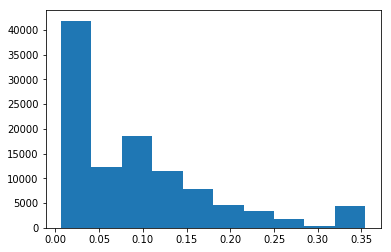

In [65]:
y_predicted = y_pred.float().detach().numpy()
plt.hist(y_predicted)

In [63]:
y_pred_scaled = (y_predicted-y_predicted.min())/(y_predicted.max()-y_predicted.min())
y_pred_scaled

array([0.21403296, 0.05113822, 0.06815433, ..., 0.02137834, 0.2550437 ,
       0.05111694], dtype=float32)

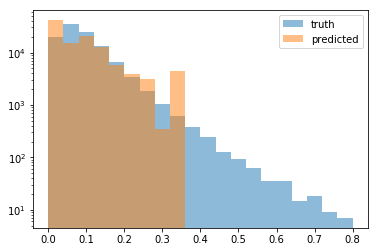

In [68]:
plt.hist(Y, 20, log=True, range=(0, 0.8), alpha=0.5, label='truth')
plt.hist(y_predicted, 20, log=True, range=(0, 0.8), alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.show()

In [18]:
for p in param_grid:
    net = Net(pd_train.shape[1], p.nodes, p.layers)
    opt = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
    criterion = nn.L1Loss()
    
    for e in range(p.epochs):
        e_loss, y_pred = train_epoch(net, opt, criterion)
        if e%100==0:
            print("[EPOCH]: %i, [LOSS]: %.6f" % (e, loss))
    p.loss = e_loss.float().detach().numpy()
    y_predicted = y_pred.float().detach().numpy()
    p.auc = sk.metrics.roc_auc_score(y_train,y_predicted)
    
    print("Nodes: "+str(p.nodes))
    print("Layers: "+str(p.layers))
    print("AUC: "+str(p.auc))
    print("Loss: "+str(p.loss))
    print("")
    
    del net, opt, criterion, e_loss, y_pred

Nodes: 25
Layers: 2
AUC: 0.4539165089700272
Loss: 0.07366418

Nodes: 50
Layers: 2
AUC: 0.48963508962105895
Loss: 0.072370686

Nodes: 100
Layers: 2
AUC: 0.6098934450319383
Loss: 0.06999898

Nodes: 200
Layers: 2
AUC: 0.7784201428511963
Loss: 0.06414894

Nodes: 25
Layers: 5
AUC: 0.4919970803162649
Loss: 0.074106306

Nodes: 50
Layers: 5
AUC: 0.5815436169625047
Loss: 0.07088808

Nodes: 100
Layers: 5
AUC: 0.7719389338314515
Loss: 0.063814275

Nodes: 200
Layers: 5
AUC: 0.840376425101256
Loss: 0.057809595

Nodes: 25
Layers: 8
AUC: 0.50397653339345
Loss: 0.07337108

Nodes: 50
Layers: 8
AUC: 0.5632142106133629
Loss: 0.071587294

Nodes: 100
Layers: 8
AUC: 0.7918406362064436
Loss: 0.062480405

Nodes: 200
Layers: 8
AUC: 0.8425610916578352
Loss: 0.05782126

Nodes: 25
Layers: 12
AUC: 0.5258492637984732
Loss: 0.07325665

Nodes: 50
Layers: 12
AUC: 0.7088885435794201
Loss: 0.06810161

Nodes: 100
Layers: 12
AUC: 0.8071168821096663
Loss: 0.06039844

Nodes: 200
Layers: 12
AUC: 0.8455513636862655
Loss: 0.05

In [ ]:
y_test_pred = net(x_test)
y_test_pred

In [ ]:
plt.figure()
plt.hist2d()

In [ ]:
y_predicted = y_pred.float().detach().numpy()
auc = sk.metrics.roc_auc_score(y_train,y_predicted)

roc_array = sk.metrics.roc_curve(y_train,y_predicted)

plt.figure()
plt.plot(roc_array[1], label='AUC = '+str(auc))
plt.title("pytorch ROC")
plt.legend(loc='lower right')

Predict on test sample

In [117]:
x_test, y_test = Variable(x_test, volatile=True), Variable(y_test)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


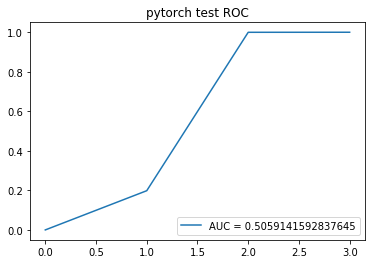

In [176]:
#y_pred_test = y_pred_test.detach().numpy()
auc = sk.metrics.roc_auc_score(y_test,y_pred_test)

roc_array = sk.metrics.roc_curve(y_test,y_pred_test)

plt.figure()
plt.plot(roc_array[1], label='AUC = '+str(auc))
plt.title("pytorch test ROC")
plt.legend(loc='lower right')